# COVID Tweets - Sentiment Analysis and Trends 

### Abstract
This notebook presents novel results of COVID sentiment analysis with concrete findings. I use off-the-shelf libraries with functional limitations, but overall results seem valid based on my analysis. 

### Introduction
The worldwide coronavirus pandemic has led to the establishment of worldwide curfews, quarantines and lockdown to mitigate further spread of the virus. During this time, it can be helpful to track the public's responses to these changes. This study aims to answer the following questions: 
1. How do people feel during the crisis? 
2. How does the general public sentiment change over time? 
3. What are the topics that most contribute to this sentiment shift? 

I filtered the data to only include tweets in English for ease of study. This section summarizes the result with a few graphs generated by the code in the latter section of the notebook. 

### Sentiment Analysis
During the COVID pandemic, [sentiment Analysis](https://monkeylearn.com/sentiment-analysis/) can be a very useful tool to help policymakers gain insight into social media data trends. Normally, sentiment analysis requires training an ML model using labelled data. However, since we don't have training data in this dataset, we opt to use pre-training modeled from the "TextBlob" package, as performed in this [example](https://www.kaggle.com/kartikmohan1999/covid19-sentiment-analysis). Although not a state-of-the-art model, it at least gives reasonable results. (I confirmed a few output cases with manual spot checks.)

From the graphs of Sentiment over Time, we notice that: 
* The overall sentiment increased in positivity by about 4% throughout the month of April, while tweet volume decreased slightly. This may reflect gradual subsiding of initial panic.
* The end of April saw a positivity spike of about 2%, which occurs right before re-opening in the USA. This boosted sentiment may be caused by an increase in morale attributed to the re-opening policy decision.

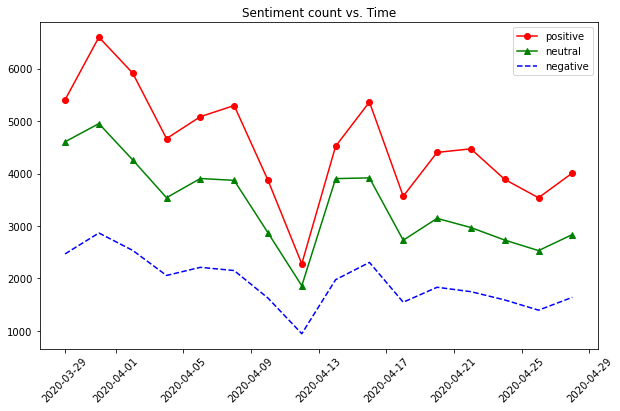
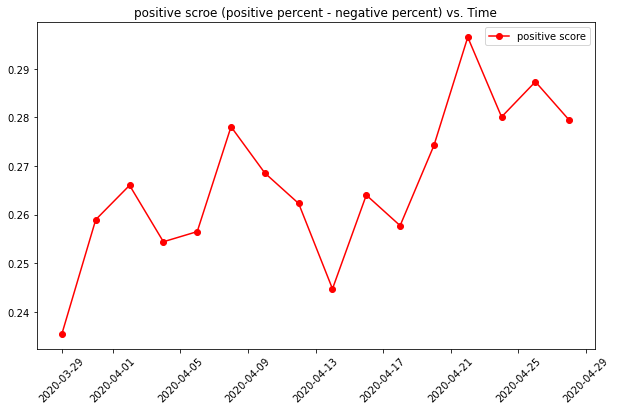

**Error analysis**: 
* The Sentiment trend graph is prone to random noise/variance if not given enough data points. On the other hand, with too many data points, the notebook runs very slowly. After tuning the data size, I confirmed that the graph is stable when the random sample partition is changed.
* I do not have measurement of the error/bias for the sentiment analysis using the "TextBlob" package library. The result seems reasonable based on manual spot checks. 

### Topic-Specific Sentiment Analysis
To answer question #3 (What are the topics that contributed to people's sentiment?), we need to gain some insights into what people are discussing in the Twitter posts. To do that, I first tried "topic modeling" with [Latent Dirichlet allocation(LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) in this [notebook](https://www.kaggle.com/esthercao/covid-topic-modelling-lda). However, the topics in COVID-related tweets seem too nuanced for the basic LDA library that I used, and the result was not promising. 

I then extracted tags and account names from the tweet corpus. This seemed to give good insights into what subjects people talk about. 

Observations from the below graphs: 
A. Negative
* In USA, negative sentiment are related to political issues such as @GOP, @WhiteHouse, @SpeakerPolosi, #donaldtrump, @FoxNews (a conservative news network), #chinesevirus/#wuhanvirus (controversial term popularized by President Trump), #trumpvirus, #maga (make america great again), @POTUS/@realDonaldTrump/#trump.
* In Britian, negative sentiment tend to be related to prominent public figures testing positive for the virus: @MattHancock, #borisjohnson. 
B. Positive
* Positive tweets seem to relate less to specific countries and more to universal topics: #love, #inthistogether, #washyourhands, #stayhomeandstaysafe. 
* The lack of topics from users in other countries (India, Austria, Canada) among the English dataset may require further investigation. Possible explanations include: they are more positive in general, are less outspoken about negative topics, or use Twitter hashtags less often.

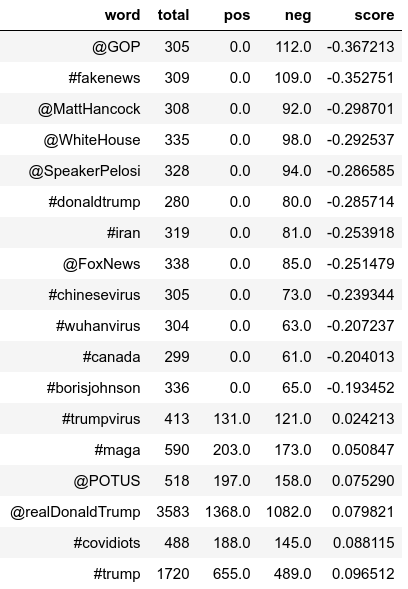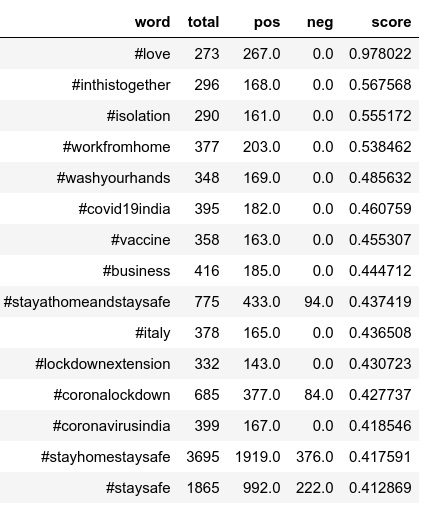

### What could be improved: 
* Better sentiment analysis tool. TextBlob sentiment analysis has a [pre-trained model](https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) that uses nltk's NaiveBayesClassifier, which does not account for sentence structure. Also, the model is trained on movie review data, which may have reduced performance when used on Twitter data. 
* Error rate for the sentiment analysis step is unknown. To measure the error rate, we may label a small (~1000s of tweets) validation data set to test the model. 
* This study did not factor in the country of the Twitter user. The Country field in the input data is very sparsely populated; if it were given for most tweets, it would allow us to study each country's data separately.
* Refine Twitter hashtag topics with NER. [Named Entity Extraction (NER)](https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da) is a very useful tool for extracting topics, such as person name, company, places, etc. This could help answer refine our answer to question 2: "What are the topics that contributed to people's sentiment?". If we did not already have Twitter hashtags and accounts in this data set, NER could be used to answer this question.
* Better data mining tool. The LDA topic mining is an older algorithm (2003) that doesn't take advantage of newer NLP development such as [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), which leverages natural language understanding and sentence structure.
* Improve processing speed. Due to speed limitations, this notebook only processed 2% of available tweets. The decreased sample set may result in more uncertainty and error margains. This notebook used python code to directly process text, which is slow. 
* Expand study to other languages
* Deeper exploration of user profile information
   1. friends_count and followers_count to quantify tweet's social media influence
   2. reply_to_screen_name, to determine connected components of people retweeting each other

### What I learned from this project: 
* General approach to sentiment analysis
* Using Kaggle, Pandas, pyplot, various packages for NLP
* Handling a large data set; loading the dataset with sampling for efficient processing


t

# Importing Packages

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)

from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

import re
from collections import Counter
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         if (filename.endswith('Tweets.CSV')) :
#             print(os.path.join(dirname, filename))

# Reading Data

In [ ]:
# Reading data
# df=pd.read_csv('/kaggle/input/coronavirus-covid19-tweets-early-april/2020-03-29 Coronavirus Tweets.CSV', skiprows=lambda i: i!=0 and (i) % 1000 != 0)

# Read all files and down-sample
df2 = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if (filename.endswith('Tweets.CSV')):
            df2.append(pd.read_csv(os.path.join(dirname, filename), header=0, skiprows=lambda i: i!=0 and (i) % 50 != 0))
df = pd.concat(df2, axis=0, ignore_index=True)

df.head()
df.shape

# Cleaning Data

In [ ]:
# display columns
print ("original columns: ")
df.columns

# dropping columns
tweet = df.copy()
tweet.drop(['status_id','user_id','screen_name','source','reply_to_status_id','reply_to_user_id','is_retweet','place_full_name','place_type','reply_to_screen_name','is_quote','followers_count','friends_count','account_lang','account_created_at','verified'],axis=1, inplace = True)
tweet.head()

In [ ]:
# filtering data with 'country_code = US' and 'language = en'
# (tweet.country_code == "US") & 
tweet =tweet[(tweet.lang == "en")].reset_index(drop = True)
tweet.drop(['country_code','lang'],axis=1,inplace=True)

# check missing values
# tweet.isna().sum()

tweet.head()

# Inspect data

In [ ]:
# shape
tweet.shape

# # Top 5 most favourited tweets:
# fav = tweet[['favourites_count','text']].sort_values('favourites_count',ascending = False)[:5].reset_index()
# for i in range(5):
#     print(i,']', fav['text'][i],'\n')
    
# #Top 5 most retweeted tweets:
# retweet = tweet[['retweet_count','text']].sort_values('retweet_count',ascending = False)[:5].reset_index()
# for i in range(5):
#     print(i,']', retweet['text'][i],'\n')

### Word Cloud : 
This word cloud doesn't help answer our questions, but is an interesting visualization. The following words can be seen: "COVID19", "resp", "Trump", "affected", "businesses"

In [ ]:
def show_wordcloud(data , title = None):
    wordcloud = WordCloud(background_color='black',stopwords=stopwords,max_words=200,max_font_size=40).generate(str(data))
  
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.title(title, size = 25)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

show_wordcloud(tweet['text'])

# Feature Extraction

In [ ]:
# Extracting hashtags and accounts
stoptags = ['#covid19', '#covid_19', '#covid-19', '#covid', '#coronavirus', '#outgreak', '#virus', '#pandemic']

tweet['tags'] = tweet['text'].str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$|\.,)')
tweet['tags'] = tweet['tags'].apply(lambda word_list:list(map(lambda w: w.lower(), word_list))).apply(lambda word_list:list(filter(lambda w: w not in stoptags, word_list)))

tweet['accts'] = tweet['text'].str.findall(r'(?:(?<=\s)|(?<=^))@.*?(?=\s|$)')
tweet['entity_text'] = tweet['tags'].apply(' '.join) + ' ' + tweet['accts'].apply(' '.join)
tweet.head()

# Data Processing

In [ ]:
# Tokenizing and Removing special charactors
for i in range(tweet.shape[0]) :
    tweet['text'][i] = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(#[A-Za-z0-9]+)", " ", tweet['text'][i]).split()).lower()
tweet['text'].head()

In [ ]:
#Removing Stop Words
stopwords

tweet['text'] = tweet['text'].apply(lambda tweets: ' '.join([word for word in tweets.split() if word not in stopwords]))
tweet['text'].head() 

## Analyzing Text for Sentiment

Using TextBlob to analyze tweets to predict text sentiment and categorize as 'Positive', 'Negative' or 'Neutral'.

In [ ]:
%time
tweet['sentiment'] = ' '
tweet['polarity'] = None
for i,tweets in enumerate(tweet.text) :
    blob = TextBlob(tweets)
    tweet['polarity'][i] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0 :
        tweet['sentiment'][i] = 'positive'
    elif blob.sentiment.polarity < 0 :
        tweet['sentiment'][i] = 'negative'
    else :
        tweet['sentiment'][i] = 'neutral'
pd.set_option('display.max_colwidth', 400)
tweet.head()

In [ ]:
print(tweet.sentiment.value_counts())
sns.countplot(x='sentiment', data = tweet);

### Expore favorite and retweet counts
A quick look at these showed that they are mostly inline with tweet count. So, we will just use tweet count for our study.

In [ ]:
count = pd.DataFrame(tweet.groupby('sentiment')['favourites_count'].sum())
count.head()

In [ ]:
count = pd.DataFrame(tweet.groupby('sentiment')['retweet_count'].sum())
count.head()

## Sentiment Distribution

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(tweet['polarity'], bins=30)
plt.title('Sentiment Distribution',size = 15)
plt.xlabel('Polarity',size = 15)
plt.ylabel('Frequency',size = 15)
plt.show();

## Sentiment Over Time

In [ ]:
# format timestamp
tweet['created_at'] = pd.to_datetime(tweet['created_at'])
tweet['created_at'] = pd.IntervalIndex(pd.cut(tweet['created_at'], pd.date_range('2020-03-29', '2020-05-01', freq='2880T'))).left

# count sentiment
tweet_count1 = tweet.groupby(['created_at','sentiment'])['text'].count().reset_index().rename(columns={'text':'count'})
tweet_count1.head()

# check missing values
# tweet_count1.isna().sum()

In [ ]:
#format sentiment table
times = tweet_count1.loc[tweet_count1['sentiment'] == 'negative']['created_at'].reset_index(drop = True)
pos = tweet_count1.loc[tweet_count1['sentiment'] == 'positive']['count'].reset_index(drop = True)
neutral = tweet_count1.loc[tweet_count1['sentiment'] == 'neutral']['count'].reset_index(drop = True)
neg = tweet_count1.loc[tweet_count1['sentiment'] == 'negative']['count'].reset_index(drop = True)

plt.figure(figsize=(10,6))
plt.xticks(rotation='45')
plt.title("Sentiment count vs. Time")

lin1=plt.plot(times, pos, 'ro-', label='positive')
lin2=plt.plot(times, neutral, 'g^-', label='neutral')
lin3=plt.plot(times, neg, 'b--', label='negative')
plt.legend()
plt.show

In [ ]:
# "score" is defined as percent of positive tweets minus percent of negative tweets
score = (pos - neg) / (pos + neutral + neg)

plt.figure(figsize=(10,6))
plt.xticks(rotation='45')
plt.title("positive scroe (positive percent - negative percent) vs. Time")

lin1=plt.plot(times, score, 'ro-', label='positive score')
plt.legend()
plt.show

# Tags with the most Negative and Postive Sentiment

In [ ]:
all_words = []
all_words = [word for i in tweet.entity_text for word in i.split()]
pos_words = tweet['entity_text'][tweet['sentiment'] == 'positive']
neg_words = tweet['entity_text'][tweet['sentiment'] == 'negative']
neutral_words = tweet['entity_text'][tweet['sentiment'] == 'neutral']
# show_wordcloud(pos_words , 'POSITIVE')
# show_wordcloud(neg_words , 'NEGATIVE')
# show_wordcloud(neutral_words , 'NEUTRAL')

def get_freq(word_list):
    freq = Counter(word_list).most_common(100)
    freq = pd.DataFrame(freq)
    freq.columns = ['word', 'frequency']
    return freq

all_freq = get_freq(all_words)
pos_freq = get_freq([word for i in pos_words for word in i.split()])
neg_freq = get_freq([word for i in neg_words for word in i.split()])

freq = pd.merge(all_freq,pos_freq,on='word',how='left').rename(columns={'frequency_x':'total','frequency_y':'pos'})
freq = pd.merge(freq,neg_freq,on='word',how='left').rename(columns={'frequency':'neg'}).fillna(0)
freq['score'] = (freq['pos'] - freq['neg'] ) / freq['total']

neg_freq_filtered = freq[(freq['score'] < 0.2) & (freq['neg'] > 0)].head(40).sort_values('score',ascending = True)

neg_freq_filtered.head(40)

In [ ]:
#Positive 
freq[(freq['score'] >0.4) & (freq['pos'] !=0)].head(40).sort_values('score',ascending = False)

In [ ]:
plt.figure(figsize = (20, 20))
sns.barplot(y="word", x="score",data=freq);

In [ ]:
# tweet.to_csv('tweet.csv',index=False)